## This notebook summarizes how subjects were included/excluded in the analysis.

In [1]:
import pandas as pd
import numpy as np

### 1. Data source: NHANES 2013-2014 (n=10175)

We are using data from the NHANES 2013-2014 survey. That survey includes 10175 subjects. Each of them has a unique "Respondent sequence number" (SEQN), which is used to identify them in the dataset.
https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#SEQN

The data from all theses subjects is downloaded in the notebook 1_download.ipynb


### 2. Excluding subjects top-coded as 80 years old (n=9823)

Due to data protection issues, NHANES decided that the age of subjects older than 80 years old would be top-coded as 80 years old (https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#RIDAGEYR).

This could cause distortion in the analysis, when assessing the relationship between age and other variables. Therefore, we exclude these subjects all subjects coded as 80 years old (n=352) from the analysis. This leaves us with 9823 subjects (between 0 and 79 years old). 

The exclusion is done in the notebook 8_data_preprocessing.ipynb

The data of the remaining subjects (n=9823) is stored in full_df.csv


In [3]:
full_df = pd.read_csv('../full_df.csv')

In [4]:
full_df.shape

(9823, 3511)

### 3. Excluding subjects without bone density data (target) (n=2897)

Our target variable is Bone Mineral Density (BMD), which is the main indicator of bone health. Speficcally, we are using femoral neck BMD.

In notebook "4_bulding_target_variable.ipynb" the BMD values are extracted from the NHANES dataset, then categorized in a binary target variable and saved in a separate file (target.csv).

Not all subjects included in the NHANES 2013-2014 database have BMD data. In fact, just 3708 subjects out of the total 10175 subjects in NHANES 2013-2014 have BMD data: https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DXXFEM_H.htm#DXXNKBMD

Of those 3708 subjects who have BMD data, not all of them have the DXXNKBMD (femoral neck BMD) data. In fact, only 3127* subjects have the DXXNKBMD data. 

*(According to the website https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DXXFEM_H.htm#DXXNKBMD, there should be one less, that is 3126, but in notebook "4_bulding_target_variable.ipynb", when excluding NaNs from the original 3708, then 3127 are left, and I haven't identified any weird value).

The Femoral Neck BMD values of those 3127 subjects are stored in target.csv, as well as the binary target variable (1=Osteoporosis or Osteopenia, 0=Normal).

So, at this point we had 9823 subjects in full_df.csv and 3127 subjects in target.csv. But not all subjects in target.csv are in full_df.csv. Therefore, we need to exclude the subjects in full_df.csv that are not in target.csv. In other words, in full_df we need to keep only the subjects that have BMD data (target). This exclusion was performed in "9_split_dataset.ipynb". In that notebook, it was found that from the 9823 subjects in full_df.csv, 6926 had no BMD data and were excluded. This left us with 2897 subjects. It can be therefore concluded that 3127 - 2897 = 230 subjects had BMD data but were excluded from the analysis because they were coded as 80 years old (and therefore there were not in full_df.csv).


### 4. Excluding subjects with no accelerometer (physical activity) data (n=2569)

Not all of the 10175 subjects in NHANES 2013-2014, had accelerometer data. As described in https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXMIN_H.htm#Analytic_Notes, a total of 7776 subjects wore the physical activity monitor (PAM) in that cycle. 

Now we analyzed the accelerometer data in two different ways:


1. In notebook "5_physical_activity_feature_engineering.ipynb" we engineered a number of features from the accelerometer data. Those features were saved in pax.csv and they would be used in tabular form by 'classic' machine learning models in "11_baseline_classification.ipynb".


In [11]:
pax = pd.read_csv('../pax.csv')
pax.shape

(7776, 20)

2. In notebook "6_generate_time_series_matrix.ipynb" we organized the acceleration time series in a matrix to be employed later in a deep learning model. In that notebook we also checked that 7776 subjects had accelerometer data.
But in this case, out of those 7776 subjects, we decided to include only those who have at least 7 days of data with 1440 (24x60) minutes per each of those 7 days. This is because we want to have a complete week of data for each subject. So this would exclude 239 subjects leaving us with 7537 subjects. The times series matrix generated there had therefore a dimension of (7537 subjects, 7 days, 1440 minutes).

In [10]:
matrix = np.load('../matrix_3d.npy')
matrix.shape

(7537, 7, 1440)

Important: In notebook "9_split_dataset.ipynb", we found that from the 2897 subjects with BMD data, 328 had no accelerometer data and were excluded. This left us with 2569 subjects. Please note that this exclusion was based on the accelerometer data used in the baseline classification approach (pax.csv), not on the accelerometer data used in the deep learning approach (time series matrix). Specifically, the exclusion was based on dropping those subjects that had a NaN at the variable PAXMINSB (df=df.dropna(subset=['PAXMINSB'])). PAXMINSB was one of the variable'engineered' in notebook "5_physical_activity_feature_engineering.ipynb", and in there we didn't exclude those who did not have a complete week of data, as we did in notebook "6_generate_time_series_matrix.ipynb". Instead, we processed all minutes that had been flagged as 'valid' by NHANES and did a weighted average. That's why we have 7776 subjects in pax.csv and 7537 subjects in the time series matrix.
Therefore, being rigorous we did not apply the same exclusion criteria for accelerometer data (used in the baseline_classification) as we did for the time series matrix (used in the deep learning approach). There is a difference of 239 subjects between the two approaches. I believe that the difference is not significant and that the two approaches can be compared.

In [5]:
pax.shape, matrix.shape

((7776, 20), (7537, 7, 1440))

### 5. Excluding subjects with no body weight data (n=2565)

In the baseline classification we didn't only use the accelerometer data, but also 3 additional features, that are relevant for bone health: body weight, age and gender. In notebook "9_split_dataset.ipynb" we found that from the 2569 subjects that had been included so far, 4 had no body weight data and were excluded. This left us with 2565 subjects. This was the final sample size.

### 6. Training (n=2052) and test (n=513) sets

In notebook "9_split_dataset.ipynb" we split the 2565 subjects into training (80%) and test (20%) sets. This resulted in 2052 subjects in the training set and 513 subjects in the test set.

Here’s a summary of the inclusion and exclusion criteria for the study participants:

- Initial Cohort: 10,175 participants from NHANES 2013-2014.
- Exclusion 1: 352 participants aged 80 years (top-coded as 80), leaving 9,823 participants.
- Exclusion 2: Out of these, 6,925 participants did not have Bone Mineral Density (BMD) data, reducing the number to 2,897.
- Exclusion 3: 328 participants without accelerometer data were further excluded, resulting in 2,569 participants.
- Exclusion 4: 4 participants without body weight data were excluded, finalizing the count at 2,565 participants.
- Final Split: These were then split into training (2,052 participants) and test groups (513 participants).

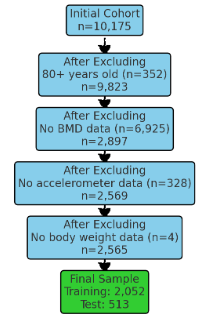

In [12]:
from IPython.display import Image
Image("Captura.png")
